In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import colorsys
import umap
import pickle as pk
from fa2 import ForceAtlas2
import pymysql as mysql
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
from prettytable import PrettyTable
from fisher import pvalue
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection,cluster)
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
# import statsmodels.sandbox.stats.multicomp as mc
import matplotlib.pyplot as plt
# %matplotlib inline

import plotly.plotly as py
import plotly
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot
# import seaborn as sns; sns.set(color_codes=True)


init_notebook_mode(connected=True)

In [2]:


# ███╗   ███╗███████╗███╗   ██╗ ██████╗██╗  ██╗███████╗
# ████╗ ████║██╔════╝████╗  ██║██╔════╝██║  ██║██╔════╝
# ██╔████╔██║█████╗  ██╔██╗ ██║██║     ███████║█████╗  
# ██║╚██╔╝██║██╔══╝  ██║╚██╗██║██║     ██╔══██║██╔══╝  
# ██║ ╚═╝ ██║███████╗██║ ╚████║╚██████╗██║  ██║███████╗
# ╚═╝     ╚═╝╚══════╝╚═╝  ╚═══╝ ╚═════╝╚═╝  ╚═╝╚══════╝
                                                     




#####################################################################################
#
#         P P I  N E T W O R K
#
#    SQL STATEMENT EXECUTED IN PYTHON
#    RETURNS THE PPI AS A NETWORKX GRAPH 
#    OPTIONS:
#            - G = get_ppi(0)  CONTAINS ALL CONNECTED COMPONENTS
#            - G = get_ppi(1)  CONTAINS ONLY LCC (Largest Connected Component)
#
#    IMPLEMENTED FILTERS ARE:
#            - NO SELFLOOPS
#            - ONLY PROTEIN CODING GENES ARE INCLUDED 
#            - ONLY CONNECTIONS THAT HAVE AN AUTHOR AND PubMed ID ARE INCLUDED
#
#
####################################################################################
import pymysql as mysql



def get_ppi(lcc):
    
    # Open database connection
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT
            e.entrez_1,
            e.entrez_2,
            g1.Locus_Type,
            g1.Locus_Group,
            g2.Locus_Type,
            g2.Locus_Group
            FROM networks.PPI_hippie2017 e
            INNER JOIN GenesGO.hgnc_complete g1 ON e.entrez_1 = g1.Entrez_Gene_ID_NCBI
            INNER JOIN GenesGO.hgnc_complete g2 ON e.entrez_2 = g2.Entrez_Gene_ID_NCBI
            WHERE 
                (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'T cell receptor gene')	          # 0 links    
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'immunoglobulin gene')              # 4 links    
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'T cell receptor gene')             # 0 links
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'immunoglobulin gene') 	          # 0 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'gene with protein product')       # 17 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'T cell receptor gene')       # 1 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'gene with protein product')        # 115 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'immunoglobulin gene')        # 295 links    
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'gene with protein product')  # 309602 links  

        
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    l_nodes = []
    for x in data:
        l_nodes.append(x[0])
        l_nodes.append(x[1])
    l_nodes = list(set(l_nodes))

    G = nx.Graph()
    G.add_nodes_from(l_nodes)
    
    for x in data:
        G.add_edge(x[0],x[1])
    
    if lcc == 1:
        Nl_l = sorted(nx.connected_components(G)) # generates list of components node lists
        l = [len(x) for x in Nl_l] # returns list of length of node lists 
        idx = l.index(max(l))   # find the index of the maximal length i.e. lcc
        Nlcc = Nl_l[idx]    # pin down lcc
        G_lcc = G.subgraph(Nlcc)   # extract lcc graph
        G = G_lcc.copy()
    else:
        pass
    
    return G


#######                                                            #######
#                                                                        #     
#               TRANSLATES GENE SYMBOLS TO ENTREZ AND VV                 #
#                                                                        #  
#######                                                            #######
def genent2sym():

    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")    

    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """   SELECT
                    Approved_Symbol,
                    Entrez_Gene_ID_NCBI 
                FROM GenesGO.hgnc_complete
                WHERE Entrez_Gene_ID_NCBI != ''
          """ 

    cursor.execute(sql)
    data = cursor.fetchall()    
#     try: 
#         # execute SQL query using execute() method.
#         cursor.execute(sql)
#         data = cursor.fetchall()
#     except:
#         print('SQL error')
    db.close()

#     t0 = time.time()
    d_sym_ent = {}
    d_ent_sym = {}

    for x in data:
        sym = x[0]
        ent = x[1]
        d_sym_ent[sym] = ent
        d_ent_sym[ent] = sym
#     print(time.time()-t0)
    
    return d_ent_sym, d_sym_ent


#########################################################################
#
#               G E N E S  2  N A M E S
#
#          GENERATES DICT FOR GENE ID 2 NAMES ASSOCIATIONS
#
#########################################################################
def loadgenenames():      
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql =   """
            SELECT
                Entrez_Gene_ID_NCBI,
                Approved_Symbol,
                Approved_Name
            FROM hgnc_complete
            WHERE GeneStatus LIKE 'Approved'
            """ 
    try: 
        # execute SQL query using execute() method.
#         cursor.Base.execute_query(sql)
        cursor.execute(sql)
        data = cursor.fetchall()
    except:
        print('SQL error')
    db.close()

    d_entz_names = {}
    c = 0
    for xx in data:
        c +=1
        entz = xx[0]
        name = xx[2]
        d_entz_names[entz] = name
        
    return d_entz_names


#########################################################################
#
#                  P H E N O T Y P E    
# 
#########################################################################
#
#         P H E N O T Y P E    O N T O L O G Y
#
#          GENERATES GENE ONTOLOGY TREE GRAPH
#
#########################################################################
def HPO_tree(graphtype,stream = 'up'):
     
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","HumanPhenotypes")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql_tree =  """
                SELECT
                    hp_id,
                    hp_name,
                    is_a
                FROM HumanPhenotypes.phenotype_tree
                WHERE is_obsolete NOT LIKE 'true'
                """ 
    
    cursor.execute(sql_tree)
    data_tree = cursor.fetchall()

#     try: 
#         # execute SQL query using execute() method.
#         cursor.execute(sql_tree)
#         data_tree = cursor.fetchall()
#     except:
#         print('GO tree SQL error')

    db.close()
    if graphtype == 'directed':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
        
    d_HPOterms_name = {}
    c = 0
    for x in data_tree:
        c +=1
        G.add_node(x[0])
        d_HPOterms_name[x[0]] = x[1]
 
    tip = 'HP:0000001'
#     G.add_node(tip)

    if stream == 'up':
        
        # 1st condition to make a link
        # Node A get a directed link to B whenever there is B in the list of the 'is_a' column
        for x in data_tree:
            hp_id = x[0]
            is_a = x[2]
            l_connectors = is_a.split(',HP')
            if hp_id != tip:
                for cons in l_connectors:
                    target = 'HP:' + cons.split(':')[1].split('!')[0][:-1]
                    G.add_edge(hp_id,target)
    
    else:
        # down   
        # 1st condition to make a link
        # Node A get a directed link to B whenever there is B in the list of the 'is_a' column
        for x in data_tree:
            hp_id = x[0]
            is_a = x[2]
            l_connectors = is_a.split(',HP')
            if hp_id != tip:
                for cons in l_connectors:
                    target = 'HP:' + cons.split(':')[1].split('!')[0][:-1]
                    G.add_edge(target,hp_id)

    return G, tip, d_HPOterms_name


#########################################################################
#
#               G E N E  2  HPO
#
#          GENERATES DICT FOR GENE TO HPO ASSOCIATIONS
#
#########################################################################    
def gene2hp():
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","HumanPhenotypes")    

    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """ 
        SELECT DISTINCT
            gene_id_entrez,
            HPO_ID
        FROM disease_gene_phenotype_all
          """ 
    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql)
        data = cursor.fetchall()
    except:
        print('SQL error')
    db.close()

#     t0 = time.time()
    d_gene_hp = defaultdict(list)
    d_hp_gene = defaultdict(list)


    for x in data:
        gene = str(x[0])
        hp = x[1]
        d_gene_hp[gene].append(hp)
        d_hp_gene[hp].append(gene)
        
    return d_gene_hp, d_hp_gene

#########################################################################
#
#          COLLECT ALL UPSTREAM TERMS FROM ONTOLGY AND
#          GENERATES DICT FOR GENE TO HPO+UPSTREAM TERMS 
#
######################################################################### 
def hpo_upstream_relations(ppionly = 1):
    
    G_up, tip, d_HPOterms_name = HPO_tree('directed',stream = 'up')

    d_gene_hp, d_hp_gene = gene2hp()

    if ppionly == 1:
        G_ppi = get_ppi(1)
        # upstream gene 2 branch association
        d_gene_hpup = {}
        c = 0
        for gene, hps in d_gene_hp.items():
            if gene in G_ppi:
                all_set = set()
                for hp in hps:
                    branch = nx.descendants(G_up,hp)
                    branch.add(hp)
                    all_set = all_set.union(branch)
                d_gene_hpup[gene] = all_set
            
        # turn dictionary
        d_uphp_genes = defaultdict(list)
        for gene, hps in d_gene_hpup.items():
            for hp in hps:
                d_uphp_genes[hp].append(gene)
        
        d_uphp_setgenes = {}
        for hp, genes in d_uphp_genes.items():
            d_uphp_setgenes[hp] = set(genes)

    else:
        # upstream gene 2 branch association
        d_gene_hpup = {}
        c = 0
        for gene, hps in d_gene_hp.items():
            all_set = set()
            for hp in hps:
                branch = nx.descendants(G_up,hp)
                branch.add(hp)
                all_set = all_set.union(branch)
            d_gene_hpup[gene] = all_set
            
        # turn dictionary
        d_uphp_genes = defaultdict(list)
        for gene, hps in d_gene_hpup.items():
            for hp in hps:
                d_uphp_genes[hp].append(gene)
        
        d_uphp_setgenes = {}
        for hp, genes in d_uphp_genes.items():
            d_uphp_setgenes[hp] = set(genes)
            
    return d_gene_hpup, d_uphp_setgenes

#########################################################################
#########################################################################



#########################################################################
#
#               D I S E A S E  O N T O L O G Y
#
#          GENERATES DISEASE ONTOLOGY TREE GRAPH
#
#########################################################################
def Disease_ontology(graphtype, stream = 'up'):      
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","Gene2Disease")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql_tree =  """
                    SELECT 
                        do_id,
                        is_a-- ,
                    -- LENGTH(is_a) - LENGTH(REPLACE(is_a, '!', '')) counts
                    FROM Gene2Disease.disease_ontology
                    WHERE is_obsolete = ''
                    -- ORDER BY counts desc
                """ 
    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql_tree)
        data_tree = cursor.fetchall()
    except:
        print('GO tree SQL error')
    db.close()
    if graphtype == 'directed':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
        
    l_DOterms = []
    c = 0
    for x in data_tree:
        c +=1
        #if c < 10:
        #l_GOterms.append(x[0])
        G.add_node(x[0])

    # tip of dieseast tree: 'disease'
    
    tree_tip = 'DOID:4'
    G.add_node(tree_tip)
    
    
    if stream == 'up':
        # 1st condition to make a link
        # Node A get a directed link to B whenever there is B in the list of the 'is_a' column
        c = 0
        for x in data_tree:
            do_id = x[0]
            is_a = x[1]
            n_entries_inCol = int(is_a.count('!')) 
#             print(n_entries_inCol)
            for n in range(1,n_entries_inCol+1):
                c += 1
                do_id_2 = str('DO' + str(is_a.split('DO')[n].split('!')[0])).strip()
#                 print(do_id)
#                 print(do_id_2[:-1], len(do_id_2))
                G.add_edge(do_id,do_id_2)
    else:
        # 1st condition to make a link
        # Node A get a directed link to B whenever there is B in the list of the 'is_a' column
        c = 0
        for x in data_tree:
            do_id = x[0]
            is_a = x[1]
            n_entries_inCol = int(is_a.count('!')) 
#             print(n_entries_inCol)
            for n in range(1,n_entries_inCol+1):
                c += 1
                do_id_2 = 'DO' + str(is_a.split('DO')[n].split('!')[0])
#                 print(do_id)
#                 print(do_id_2[:-1], len(do_id_2))
                G.add_edge(do_id_2[:-1],do_id)        
            


    return G, tree_tip

#########################################################################
#
#               D I S E A S E  2  N A M E S
#
#          GENERATES DICT FOR DISEASE ID 2 NAMES ASSOCIATIONS
#
#########################################################################
def loaddiseasenames():      
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","Gene2Disease")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql =  """
            SELECT DISTINCT
                do_id,
                do_name
            FROM disease_ontology
            """ 
    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql)
        data_gd = cursor.fetchall()
    except:
        print('SQL error')
    db.close()

    d_do_names = {}
    c = 0
    for xx in data_gd:
        c +=1
        doid = xx[0]
        name = xx[1]
        d_do_names[doid] = name
        
    return d_do_names



#########################################################################
#
#               G E N E  2  D I S E A S E
#
#          GENERATES DICT FOR GENE TO DISEASE ASSOCIATIONS
#
#########################################################################
def loadgene2do():      
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","Gene2Disease")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql =  """
                SELECT DISTINCT
                    mp.identifier,
                    gd.entrezId
                FROM Gene2Disease.gene2disease gd
                INNER JOIN HumanPhenotypes.umlsmapping mp
                ON mp.disease_ID = gd.diseaseID
                WHERE mp.vocabulary = 'DO'
                """ 
    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql)
        data_gd = cursor.fetchall()
    except:
        print('GO tree SQL error')
    db.close()

    d_gene_do = defaultdict(list)
    d_do_gene = defaultdict(list)


    c = 0
    for xx in data_gd:
        c +=1
        gene = xx[1]
        do = 'DOID:' + str(xx[0]) 
        d_gene_do[gene].append(do)
        d_do_gene[do].append(gene)


    return d_gene_do, d_do_gene


def do_upstream_relations(ppionly = 1):


    G_DO, tree_tip = Disease_ontology('directed',stream = 'up')
    # load pure DO associations from Disgenet 
    d_gene_do, d_do_gene = loadgene2do()


    # Check for DO IDs, that are not in the Graph
    l_do = []
    for dos in d_gene_do.values():
        for do in dos:
            l_do.append(do.strip())
    l_exclude_dos = set(l_do) - set(G_DO.nodes())

    # print(l_do[:10])        
#     print('number of diseases associated to genes: %s' %len(list(set(l_do))))
#     print('number of diseases in ontology: %s' %G_DO.number_of_nodes())
#     print('number of diseases not in the ontology: %s' %(len(l_exclude_dos)))
    # print(l_exclude_dos)


    ###################################
    #                                 #
    #    UPSTREAM TERM ASSOCIATION    #
    #                                 #
    ###################################

    if ppionly == 1:
        G = get_ppi(1)
        d_updo_genes = defaultdict(list)
#         print('number of genes associated to disease: %s' %len(d_gene_do.keys()))
        for gene in d_gene_do.keys():
            if gene in G_ppi.nodes():
                # loop over all disease purely associated to a gene
                for dos in d_gene_do[gene]:
                    if dos not in l_exclude_dos:
                        p_c = 1
                        for updos in nx.shortest_simple_paths(G_DO,dos,tree_tip):
                            for dis in updos:
                                d_updo_genes[dis].append(gene)
                                p_c += 1

        # remove redundant annotations
        d_updo_geneset = {}    
        for k, v in d_updo_genes.items():
            d_updo_geneset[k] = list(set(v))

        # invert dictionary here:
        d_gene_updo = defaultdict(list)
        for k, v in d_updo_geneset.items():
            for gene in v:
                d_gene_updo[gene].append(k)

        d_gene_updoset = {}    
        for k, v in d_gene_updo.items():
            d_gene_updoset[k] = list(set(v))

    else:
        d_updo_genes = defaultdict(list)
        print('number of genes associated to disease: %s' %len(d_gene_do.keys()))
        for gene in d_gene_do.keys():
            # loop over all disease purely associated to a gene
            for dos in d_gene_do[gene]:
                if dos not in l_exclude_dos:
                    p_c = 1
                    for updos in nx.shortest_simple_paths(G_DO,dos,tree_tip):
                        for dis in updos:
                            d_updo_genes[dis].append(gene)
                            p_c += 1

        # remove redundant annotations
        d_updo_geneset = {}    
        for k, v in d_updo_genes.items():
            d_updo_geneset[k] = list(set(v))

        # invert dictionary here:
        d_gene_updo = defaultdict(list)
        for k, v in d_updo_geneset.items():
            for gene in v:
                d_gene_updo[gene].append(k)

        d_gene_updoset = {}    
        for k, v in d_gene_updo.items():
            d_gene_updoset[k] = list(set(v))
            
    del d_updo_genes  
    del d_gene_updo
    
    return d_gene_updoset, d_updo_geneset



#########################################################################
#########################################################################



#########################################################################
#
#               G E N E   O N T O L O G Y
#
#          GENERATES DISEASE ONTOLOGY TREE GRAPH
#
#########################################################################


def GO_tree(branch_category,graphtype,stream = 'up'):
    
    if branch_category == 'cell':
        cat = 'cellular_component'
    if branch_category == 'mol':
        cat = 'molecular_function'
    if branch_category == 'bio':
        cat = 'biological_process'        
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql_tree =  """
                    SELECT DISTINCT go_id,is_a,relationship 
                    FROM GO_tree WHERE is_a != '' 
                    AND namespace in ('%s')
                """ %(cat)
    
    cursor.execute(sql_tree)
    data_tree = cursor.fetchall()

#     try: 
#         # execute SQL query using execute() method.
#         cursor.execute(sql_tree)
#         data_tree = cursor.fetchall()
#     except:
#         print('GO tree SQL error')

    db.close()
    if graphtype == 'directed':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
        
    l_GOterms = []
    c = 0
    for x in data_tree:
        c +=1
        #if c < 10:
        #l_GOterms.append(x[0])
        G.add_node(x[0])

        
    if branch_category == 'cell':
        # 'cellular_component':'GO:0005575'
        tip = 'GO:0005575'
    if branch_category == 'mol':
        # 'molecular_function':'GO:0003674'  
        tip = 'GO:0003674'
    if branch_category == 'bio':
        # 'biological_process':'GO:0008150'  
        tip = 'GO:0008150'
    G.add_node(tip)

    if stream == 'up':
        
        # 1st condition to make a link
        # Node A get a directed link to B whenever there is B in the list of the 'is_a' column
        c = 0
        for x in data_tree:
            go_id = x[0]
            is_a = x[1]
            n_entries_inCol = int(is_a.count('!')) 
            for n in range(0,n_entries_inCol):
                c += 1
                G.add_edge(go_id,is_a.split('!')[n][-11:-1])

        # 2nd condition to make a link
        # Node A get a directed link to B whenever there is B as part_of/regulates in the list of the 'relationship' column
        c = 0
        for x in data_tree:
            go_id = x[0]
            is_a = x[1]
            rel = x[2]
            n_entries_inCol = int(rel.count('!')) 
            if n_entries_inCol > 0:
                for n in range(0,n_entries_inCol):
                    c += 1
                    #print(rel.split('!')[n][-11:-1])
                    G.add_edge(go_id,rel.split('!')[n][-11:-1])        

    else:
        # down   

        # 1st condition to make a link
        # Node A get a directed link to B whenever there is B in the list of the 'is_a' column
        c = 0
        for x in data_tree:
            go_id = x[0]
            is_a = x[1]
            n_entries_inCol = int(is_a.count('!')) 
            for n in range(0,n_entries_inCol):
                c += 1
                G.add_edge(is_a.split('!')[n][-11:-1],go_id)

        # 2nd condition to make a link
        # Node A get a directed link to B whenever there is B as part_of/regulates in the list of the 'relationship' column
        c = 0
        for x in data_tree:
            go_id = x[0]
            is_a = x[1]
            rel = x[2]
            n_entries_inCol = int(rel.count('!')) 
            if n_entries_inCol > 0:
                for n in range(0,n_entries_inCol):
                    c += 1
                    #print(rel.split('!')[n][-11:-1])
                    G.add_edge(rel.split('!')[n][-11:-1],go_id)
                
                

    return G, tip


"""
function gets GO branch as input
returns dictionary gene: go_list (upstream included)
and go: gene_list
categories: cell, mol, bio
"""
def gene2go(branch_category):
    
    
    if branch_category == 'cell':
        branch = 'C'
    if branch_category == 'mol':
        branch = 'F'
    if branch_category == 'bio':
        branch = 'P'        
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")    

    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """ SELECT DISTINCT
                g.entrezid,
                -- g.go_id,
                u.up_ids,
                g.aspect
            FROM GenesGO.Gene2GO_human g
            INNER JOIN GenesGO.GO_upterms u
            on u.go_id = g.go_id
            WHERE g.entrezid != '-'
            AND g.evidence != 'ND' 
            AND g.evidence != 'IEA'
            AND g.evidence != 'IPI'
            AND g.aspect = '%s'
          """ %branch
    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql)
        data = cursor.fetchall()
    except:
        print('SQL error')
    db.close()

#     t0 = time.time()
    d_go_gene = defaultdict(list)
    d_gene_go = defaultdict(list)

    for x in data:
        gene = x[0]
        go = x[1]
        d_gene_go[gene].append(go)
        d_go_gene[go].append(gene)
#     print(time.time()-t0)
    
    return d_gene_go, d_go_gene

"""

function gets list of GO term-IDs as input 
and returns a dictionary of keys: GO-IDs values: GO-names

"""

def GOnames(category = 'cell'):
    
    if category == 'bio':
        branch = 'biological_process'
    elif category == 'mol':
        branch = 'molecular_function'
    else:
        branch = 'cellular_component'
    
    # Open database connection
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql_goname = """ SELECT go_id,go_name FROM GO_tree WHERE namespace = '%s' """ %branch 

    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql_goname)
        data_goidname = cursor.fetchall()

    except:
        print('load GO IDs to GO names -  SQL error')
    db.close()
    #print(data_goidname)
    d_go_id_name = {}    
    for x in data_goidname:
        d_go_id_name[x[0]] = (x[1])
    
    return d_go_id_name

#########################################################################
#########################################################################


#########################################################################
# 
#                   P A T H W A Y S 
#
#########################################################################

def keggpathw2genes():
    
    # Open database connection
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","Gene2Pathways")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT
                label,
                gene_entID
            FROM Gene2Pathways.gene2pathways
            WHERE pw_type = 'KEGG'
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    
    d_gene_keggpw = defaultdict(list)
    d_keggpw_gene = defaultdict(list)


    c = 0
    for xx in data:
        c +=1
        gene = xx[1]
        pw = xx[0] 
        d_gene_keggpw[gene].append(pw)
        d_keggpw_gene[pw].append(gene)


    return d_gene_keggpw, d_keggpw_gene

def reactpathw2genes():
    
    # Open database connection
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","Gene2Pathways")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT
                label,
                gene_entID
            FROM Gene2Pathways.gene2pathways
            WHERE pw_type = 'REACTOME'
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    
    d_gene_reactpw = defaultdict(list)
    d_reactpw_gene = defaultdict(list)


    c = 0
    for xx in data:
        c +=1
        gene = xx[1]
        pw = xx[0] 
        d_gene_reactpw[gene].append(pw)
        d_reactpw_gene[pw].append(gene)


    return d_gene_reactpw, d_reactpw_gene
    
#########################################################################
#########################################################################


#########################################################################
# 
#                   T I S S U E
#
#########################################################################
    
    
def tissue2genes():
    
    # Open database connection
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","Gene2Tissue")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT DISTINCT
                g.Approved_Symbol,
                g.Entrez_Gene_ID_NCBI,
                t.tissue
            FROM Gene2Tissue.gene2tissue t
            INNER JOIN GenesGO.hgnc_complete g
            ON t.genesymbol=g.Approved_Symbol
            WHERE t.level_class != 'Not detected'
            AND t.reliabilty != 'Uncertain'
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    
    d_gene_ts = defaultdict(list)
    d_ts_gene = defaultdict(list)
#     d_genesym_ent = defaultdict(list)
#     d_geneent_sym = defaultdict(list)


    c = 0
    for xx in data:
        c +=1
        gene = xx[1]
        sym = xx[0]
        ts = xx[2] 
        d_gene_ts[gene].append(ts)
        d_ts_gene[ts].append(gene)
#         d_genesym_ent[sym].append(gene)
#         d_geneent_sym[gene].append(sym)


    return d_gene_ts, d_ts_gene


##########################################################################################
##########################################################################################

##########################################################################################
#
#  function gets an integer number
#  and returns n HEX colors that are most distinct to each other 
#
##########################################################################################

def color_creator(n):

    colors = [colorsys.hsv_to_rgb(1.0/n*x,1,1) for x in range(n)]
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
        
    return color_list

##########################################################################################
#
#  function gets an integer number
#  and returns n/4 HEX colors that are most distinct to each other 
#  plus their 3 corresponding color values for 60% saturation and/or 
#  60% light-level
#
##########################################################################################

def color_creator_more(n):
    k = n%4
    m = int(((n+4)-k)/4)
    colors_1 = [colorsys.hsv_to_rgb(1.0/m*x,1,1) for x in range(m)]
    colors_2 = [colorsys.hsv_to_rgb(1.0/m*x,.6,1) for x in range(m)]
    colors_3 = [colorsys.hsv_to_rgb(1.0/m*x,1,.6) for x in range(m)]
    colors_4 = [colorsys.hsv_to_rgb(1.0/m*x,.6,.6) for x in range(m)]


    colors = colors_1 + colors_2 +  colors_3 + colors_4
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
#     for c in colors_2:
#         cc = [int(y*255) for y in c]
#         color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
    return color_list

###############################################
#                                             #
#  IDENTIFY THE MOST FITTING TERM             #
#  TO NAME A CLUSTER                          #
#  TAKE TERM OF MAXIMAL FREQUENCY AND SELECT  #
#  THE MOST SPECIFIC AMONG THEM               #
#                                             #
###############################################

def most_informative_label(List,n,G_tree, tree_tip): 
#     overlap_set = set(d_updo_geneset[t]) & set(List)
    list1 = [ elem for elem in List if elem != tree_tip] 


    occurence_count = Counter(list1) 
    d_term_freq = occurence_count.most_common(n)
    max_f = d_term_freq[0][1]
    # Get all term with maximal frequency
    l_pot_terms = []
    for term, freq in d_term_freq:
        if freq < max_f:
            break
        else:
            l_pot_terms.append(term)
#     print(l_pot_terms)        
    # pick term with highest specificity (max dist to tree tip) 
    taken_spec = 0
    taken_term = ''
    for term in l_pot_terms:
        specificity =  nx.shortest_path_length(G_tree,term,tree_tip)
        if specificity > taken_spec:
            taken_spec = specificity
            taken_term = term
        else:
            pass
        
    return taken_term

In [8]:


#  █████╗ ███████╗██╗███╗   ███╗ ██████╗ ██╗   ██╗
# ██╔══██╗██╔════╝██║████╗ ████║██╔═══██╗██║   ██║
# ███████║███████╗██║██╔████╔██║██║   ██║██║   ██║
# ██╔══██║╚════██║██║██║╚██╔╝██║██║   ██║╚██╗ ██╔╝
# ██║  ██║███████║██║██║ ╚═╝ ██║╚██████╔╝ ╚████╔╝ 
# ╚═╝  ╚═╝╚══════╝╚═╝╚═╝     ╚═╝ ╚═════╝   ╚═══╝  
                                                
##########################################################################################
#
#  CONVERTS ENTREZ IDs into INTERNAL IDs ans vv
#
##########################################################################################


def jenids2entzids():
    
    # Open database connection
    db = mysql.connect("asimov.westeurope.cloudapp.azure.com","readonly","ra4Roh7ohdee","ppi")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT 
            id as j_id,
            external_id as entz_id
            FROM ppi.nodes
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    d_j_e = {}
    d_e_j = {}
 

    c = 0
    for xx in data:
        c +=1
        jid = xx[0]
        eid = xx[1]
        d_j_e[jid] = eid
        d_e_j[eid] = jid


    return d_j_e, d_e_j

##########################################################################################
#
#  CONVERTS FUNCTIONs IDs into INTERNAL IDs ans vv
#  (DISEASES ONLY BY  id<10000)
#
##########################################################################################


def attributes_lookup():
    
    # Open database connection
    db = mysql.connect("asimov.westeurope.cloudapp.azure.com","readonly","ra4Roh7ohdee","ppi")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT
            id, external_id, name
            FROM ppi.attributes
            WHERE namespace in ('biological_process','molecular_function','cellular_component')
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    d_i_a = {x[0]:x[1] for x in data}
    d_a_i = {x[1]:x[0] for x in data}
    d_i_name = {x[0]:x[2] for x in data}


    return d_i_a, d_a_i, d_i_name



############################################################################################################
#
#   RETURNS DICTIONARY WITH attribute internal id as key and list of genes internal id as values
#  (DISEASES ONLY BY attribute_id<10000)
#
############################################################################################################


def get_genes4attribs():
#     print(att_id)

    # Open database connection
    db = mysql.connect("asimov.westeurope.cloudapp.azure.com","readonly","ra4Roh7ohdee","ppi")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT DISTINCT 
            	parent_id,
                nodes.id AS node_id
            FROM ppi.nodes
            JOIN ppi.nodes_attributes ON nodes.id = nodes_attributes.node_id
            JOIN ppi.attribute_taxonomies at on at.child_id = attribute_id
            WHERE at.namespace in ('GO')
          """ 
    
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()
    except:
        print('SQL error')

    db.close()    
    
    d_att_lgenes = defaultdict(list)
    
    for x in data:
        d_att_lgenes[x[0]].append(x[1])
    
    
    return d_att_lgenes
    
    

# LOAD ALL GENE ANNOTATIONS

In [26]:
t0 = time.time()


# G_ppi = get_ppi(1)

# d_ent_sym, d_sym_ent = genent2sym()



# gene ontology
# go_branch = 'cell'
# d_gene_gocell, d_gocell_gene = gene2go(go_branch)
# G_GOcell_up, celltip = GO_tree(go_branch,'directed',stream = 'up')
# G_GOcell_down, celltip = GO_tree(go_branch,'directed',stream = 'down')
# G_GOcell_un, celltip = GO_tree(go_branch,'undirected',stream = 'up')
# d_gocell_name = GOnames(category = 'cell')


# go_branch = 'mol'
# d_gene_gomol, d_gomol_gene = gene2go(go_branch)
# G_GOmol_up, moltip = GO_tree(go_branch,'directed',stream = 'up')
# G_GOmol_down, moltip = GO_tree(go_branch,'directed',stream = 'down')
# G_GOmol_un, moltip = GO_tree(go_branch,'undirected',stream = 'up')
# d_gomol_name = GOnames(category = 'mol')

go_branch = 'bio'
d_gene_gobio, d_gobio_gene = gene2go(go_branch)
G_GObio_up, biotip = GO_tree(go_branch,'directed',stream = 'up')
G_GObio_down, biotip = GO_tree(go_branch,'directed',stream = 'down')
G_GObio_un, biotip = GO_tree(go_branch,'undirected',stream = 'up')
d_gobio_name = GOnames(category = 'bio')


# # disease 
# d_gene_do, d_do_genes = do_upstream_relations(ppionly = 1)
# G_DO_up, tree_tip = Disease_ontology('directed',stream = 'up')
# G_DO_down, tree_tip = Disease_ontology('directed',stream = 'down')
# G_DO_un, tree_tip = Disease_ontology('undirected',stream = 'up')
# d_do_names = loaddiseasenames()    


# # phenotype 
# d_gene_hpo, d_hpo_genes = hpo_upstream_relations(ppionly = 1)
# G_hpo, hpo_tip, d_HPOterms_name = HPO_tree('undirected',stream = 'up')


# kegg pathways
# d_gene_keggpw, d_keggpw_gene = keggpathw2genes()

# reactome pathways
# d_gene_reactpw, d_reactpw_gene = reactpathw2genes() 

# tissues
# d_gene_ts, d_ts_gene, d_gene_ts_level = tissue2genes()


print('CPU time for getting and processing annotations: %.2f (sec)' %float(time.time()-t0))


# chose annotation:
d_gene_term = d_gene_gobio
d_term_gene = d_gobio_gene


CPU time for getting and processing annotations: 28.74 (sec)


In [27]:
d_j_e, d_e_j = jenids2entzids()
d_i_a, d_a_i, d_i_name = attributes_lookup()
# d_term_names = loaddiseasenames()    
d_term_names =  GOnames(category = go_branch)    


d_func2genes_asimov = get_genes4attribs()



In [116]:
# d_func2genes_asimov

# TEST

In [28]:
# draw random function:
func = rd.choice(list(d_term_gene))

print(func)
print('asimov ID: %s' %d_a_i[func])
print('asimov name: %s' %d_i_name[d_a_i[func]])

print('menche name: %s' %d_term_names[func])



l_intern_genes = d_func2genes_asimov[d_a_i[func]]
genes_asimov = set([d_j_e[x] for x in l_intern_genes])
if len(genes_asimov)>0:
    genes_menche = set(d_term_gene[func])

    print('Test if both sets are equal:')
    print(genes_menche.issubset(genes_asimov))
    print(genes_asimov.issubset(genes_menche))

else:
    print('no asimov genes')
    try:
        genes_menche = set(d_term_gene[func])
        print('THERE ARE Menche GENES!!')
    except KeyError:
        print('no menche genes either')


GO:0006422
asimov ID: 21449
asimov name: aspartyl-tRNA aminoacylation
menche name: aspartyl-tRNA aminoacylation
Test if both sets are equal:
True
True


In [29]:
# draw random function:
# func = rd.choice(list(d_a_i))
f = open('check_all_GO_P.csv','w')
f.write('GO ID,DO name,asimov genes, menchelab genes, both sets equal?\n')


for func in d_term_gene.keys():
    func_name = d_i_name[d_a_i[func]].replace(',',';')
    f.write('%s,%s,' %(func,func_name))
#     print('asimov ID: %s' %d_a_i[func])
#     print('asimov name: %s' %d_i_name[d_a_i[func]])

#     print('menche name: %s' %d_do_names[func])



    l_intern_genes = d_func2genes_asimov[d_a_i[func]]
    genes_asimov = set([d_j_e[x] for x in l_intern_genes])
    f.write('%s,' %len(genes_asimov))
    try:
        genes_menche = set(d_term_gene[func])
        f.write('%s,' %len(genes_menche))

    except KeyError:
        genes_menche = set()
        f.write('%s,' %0)
    
    if len(genes_asimov)>0 or len(genes_menche)>0:

        if genes_menche.issubset(genes_asimov) and genes_asimov.issubset(genes_menche):
            f.write('TRUE\n')
        else:
            f.write('FALSE\n')
    else:
        f.write('TRUE\n')


f.close()

In [30]:
len(d_term_gene)

14394

In [104]:


# draw random function:
func = 'DOID:162' #(CANCER)
func = 'DOID:4159' #(SKIN CANCER)



print(func)
print('asimov ID: %s' %d_a_i[func])
print('asimov name: %s' %d_i_name[d_a_i[func]])

print('menche name: %s' %d_do_names[func])


l_intern_genes = get_genes4attribs(d_a_i[func])
genes_asimov = set([d_j_e[x] for x in l_intern_genes])
if len(genes_asimov)>0:
    genes_menche = set(d_term_gene[func])

    print('Test if both sets are equal:')
    print(genes_menche.issubset(genes_asimov))
    print(genes_asimov.issubset(genes_menche))
    print('# genes: %s' %len(genes_asimov))
else:
    print('no asimov genes')
    try:
        genes_menche = set(d_term_gene[func])
        print('THERE ARE Menche GENES!!')
    except KeyError:
        print('no menche genes either')



DOID:4159
asimov ID: 5932
asimov name: skin cancer
menche name: skin cancer
Test if both sets are equal:
True
True
# genes: 275


In [109]:
len(set(gene_container) & set(G_ppi.nodes()))

275

In [ ]:
# SKIN CANCER - COUNT GENES BY TREE DESCENDANTS

In [106]:
# DIRECT ANNOTATIONS (NO UPSTREAM)
# d_gene_do, d_do_gene = loadgene2do()

skin_cancer = 'DOID:4159'
gene_container = []

for g in d_do_gene[skin_cancer]:
    gene_container.append(g)


    
for x in nx.descendants(G_DO_down,skin_cancer):
    print(x,d_do_names[x],len(d_do_gene[x]))
    for g in d_do_gene[x]:
        gene_container.append(g)




DOID:7566 eccrine porocarcinoma 0
DOID:4934 apocrine sweat gland cancer 0
DOID:4281 metatypical basal cell carcinoma 0
DOID:2513 basal cell carcinoma 55
DOID:6446 ceruminous carcinoma 0
DOID:5569 malignant syringoma 0
DOID:5712 cutaneous liposarcoma 0
DOID:6425 eyelid carcinoma 0
DOID:1906 malignant skin fibrous histiocytoma 0
DOID:7643 acantholytic squamous cell skin carcinoma 0
DOID:4289 micronodular basal cell carcinoma 0
DOID:7960 malignant spiradenoma 0
DOID:5273 cutaneous leiomyosarcoma 0
DOID:4279 infundibulocystic basal cell carcinoma 0
DOID:4293 clear cell basal cell carcinoma 0
DOID:4295 follicular basal cell carcinoma 0
DOID:3149 keratoacanthoma 0
DOID:8122 pseudovascular skin squamous cell carcinoma 0
DOID:5667 sweat gland carcinoma 0
DOID:13168 prepuce cancer 0
DOID:3151 skin squamous cell carcinoma 12
DOID:5591 eccrine papillary adenocarcinoma 0
DOID:10054 skin amelanotic melanoma 0
DOID:4933 apocrine adenocarcinoma 0
DOID:10044 balloon cell malignant melanoma 0
DOID:4291

In [6]:
d_ent_sym, d_sym_ent = genent2sym()



In [ ]:
# 1st Check: 
# disease 'autoimmune thyroiditis'


In [7]:
# LOAD GENE_2_OMIM AND OMIM_2_PHENOTYPE DATA FROM FILES

d_entz2omim = defaultdict(list)
d_omim2name = {}
f = open('OMIM_data/omim2gene_parsed4dataserver.txt','r')


lines = f.readlines()
for line in lines[1:]:
#     print(line)
    omim = 'OMIM:'+line.strip().split('|')[0]
    entz = line.strip().split('|')[3]
    o_name = line.strip().split('|')[1]

    d_entz2omim[entz].append(omim)
    d_omim2name[omim] = o_name

f.close()


# LOAD GENE_2_OMIM AND OMIM_2_PHENOTYPE DATA FROM FILES

d_omim2hpo = defaultdict(list)
d_hpo2name = {}
f = open('OMIM_data/omim2phenotype_parsed4dataserver.txt','r')

lines = f.readlines()
for line in lines[1:]:
    omim = line.strip().split('|')[0]
    hpo = line.strip().split('|')[1]
    hpo_name = line.strip().split('|')[2]
    evidence = line.strip().split('|')[3]
    d_omim2hpo[omim].append(hpo)
    d_hpo2name[hpo] = hpo_name
#     print(omim,hpo,hpo_name,evidence)

    
f.close()

# EXPRESSION GTEX DATA

# LOAD GENE_2_OMIM AND OMIM_2_PHENOTYPE DATA FROM FILES

d_enz_tissueexpvals = {}

# d_omim2name = {}
f = open('GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.txt','r')


lines = f.readlines()
tissues = lines[0].strip().split('\t')[2:]


for line in lines[1:]:
    sym = line.strip().split('\t')[1]
    explvls = line.strip().split('\t')[2:]
    explvls = [float(x) for x in explvls]
    try:
#         print(sym,d_sym_ent[sym])
        entz = d_sym_ent[sym]
        d_enz_tissueexpvals[entz] = explvls
    except:
        pass

f.close()


# LOAD PATENT DATA

In [8]:
# LOAD SEED SET

f = open('seed_genes_per_patient_IDs.txt','r')

lines = f.readlines()
l_seeds_entz = []
for line in lines[26:27]:
    l_seeds_entz = line.strip().split('\t')[1:]
#     print(line)
f.close()
print(l_seeds_entz)
# l_seeds_syms = [d_ent_sym[x] for x in l_seeds_entz]

l_seeds_onppi = set(G_ppi.nodes()) & set(l_seeds_entz)

print('seeds not on PPI:', set(l_seeds_entz)-set(l_seeds_onppi))
# print(l_seeds)

# LOAD SEED SET

f = open('patient_data.txt','r')

lines = f.readlines()
l_vars_syms = []
for line in lines[2:3]:
    l_vars_syms = line.strip().split('\t')[3:-2][0].split(',')
    
f.close()

l_vars_entz = [d_sym_ent[x] for x in l_vars_syms]
l_vars_onppi = set(G_ppi.nodes()) & set(l_vars_entz)
print('variants not on PPI:', set(l_vars_entz)-set(l_vars_onppi))

print(len(l_seeds_onppi))



['3561', '3718', '3575', '5788', '915', '916', '919', '11151', '27040', '5896', '5897', '64421', '5580', '79840', '3981', '204', '100', '959', '958', '29851', '917', '925', '7535', '6890', '6891', '6892', '567', '4261', '8625', '5993', '5994', '399', '9020', '5971', '7454', '7456', '10095', '472', '4683', '641', '1789', '9841', '83879', '3070', '5395', '165918', '4173', '5426', '5427', '3978', '56160', '375748', '9837', '6899', '6899', '55636', '9723', '8456', '8026', '6023', '50485', '114803', '100151683', '6774', '11005', '5238', '1736', '55651', '55505', '51750', '7012', '7015', '26277', '65057', '64858', '5073', '55135', '79991', '80169', '6948', '4522', '8517', '4792', '84876', '6786', '4860', '57217', '3431', '57724', '10616', '55072', '147372', '79633', '6777', '8085', '7403', '695', '3507', '3543', '973', '974', '29760', '5295', '6929', '5293', '5728', '930', '975', '931', '1380', '23495', '115650', '8742', '7841', '51095', '81790', '4790', '10320', '359948', '537', '57379', '7

# JSON FOR SELECTION SEED AND VARIAN LIST

In [14]:
nodes = {"variants":[{"node_id": d_e_j[x], "name": d_entz_names[x] , "symbol": d_ent_sym[x]} for x in l_vars_onppi]}

In [15]:
nodes = {"seeds":[{"node_id": d_e_j[x], "name": d_entz_names[x] , "symbol": d_ent_sym[x]} for x in l_seeds_onppi]}

In [17]:
nodes

{'seeds': [{'node_id': 1144, 'name': 'T-box 1', 'symbol': 'TBX1'},
  {'node_id': 16701,
   'name': 'interleukin 2 receptor subunit gamma',
   'symbol': 'IL2RG'},
  {'node_id': 3190,
   'name': 'cell division cycle associated 7',
   'symbol': 'CDCA7'},
  {'node_id': 17837, 'name': 'nibrin', 'symbol': 'NBN'},
  {'node_id': 10883, 'name': 'ring finger protein 168', 'symbol': 'RNF168'},
  {'node_id': 18419,
   'name': 'poly(A)-specific ribonuclease',
   'symbol': 'PARN'},
  {'node_id': 4538, 'name': 'CD3d molecule', 'symbol': 'CD3D'},
  {'node_id': 9437,
   'name': 'mannosyl-oligosaccharide glucosidase',
   'symbol': 'MOGS'},
  {'node_id': 6534,
   'name': 'SBDS ribosome assembly guanine nucleotide exchange factor',
   'symbol': 'SBDS'},
  {'node_id': 3025, 'name': 'NHP2 ribonucleoprotein', 'symbol': 'NHP2'},
  {'node_id': 4336,
   'name': 'caspase recruitment domain family member 9',
   'symbol': 'CARD9'},
  {'node_id': 10100,
   'name': 'ribonuclease H2 subunit B',
   'symbol': 'RNASEH2B

# RUN RANDOM WALK FROM SEED GENES

In [8]:
t0 = time.time()

#################################################################
#
#    GET LCC PPI HERE AND GENERATE ADJACENCY MATRIX
#
###################
#   
#    PARAMETERS

r = .9
alpha = 1.

###################


# G = nx.erdos_renyi_graph(200,.1) # test with random matrix
num_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,sorted(G.nodes()))


#################################################################
#
#    INVERT MARKOV MATRIX & GENERATE RW MATRIX
#
###################

W = rnd_walk_matrix2(A, r, alpha, num_nodes)

print('Inversion done')

#################################################################
#
#    GENERATE DICT FOR NODE-LABELS TO INTEGERS
#
###################

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1
d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


print('computing time - random walk: %.2f (sec)' %float(time.time()-t0))

Inversion done
computing time - random walk: 403.67 (sec)


In [ ]:
# LOOK FOr RANKING OF VARIANTS AMONG 

In [11]:
# START FROM SEED SET 

# PERFORM RANDOM WALK FROM SEED GENES
nodeset = []
for s_ent in l_seeds_onppi:
    nodeset.append(d_entz_idx[s_ent])

normprob = len(nodeset)
print('Size of initial set: %s seed genes\n' %normprob)
p0 = np.zeros(G_ppi.number_of_nodes())
# generate start vector
for n in range(len(p0)):
    if n in nodeset:
        p0[n] = 1.
        
pinf =  np.array(W.dot(p0))
   
# DICT WITH NODE ID AND PVIS 
d_n_p = {}
i = 0
for x in pinf:
#     print(i,x)
    d_n_p[d_idx_entz[i]] = x/normprob
    i += 1    
    
    
print('        ---- Ranked list of variants ----')
tbl = PrettyTable(['ppi rank','EntrezID','Gene symbol', '-log(p-value)', 'type'])

cc = 0
d_rk_variants = {}
cc_v = 0
for node, pvis in sorted(d_n_p.items(), key = lambda x: x[1], reverse = True):
    logp = - np.log(pvis)
    if node in l_seeds_entz:
#         print(node,d_ent_sym[node],round(logp,4),'seed')
        pass
    elif node in l_vars_entz:
#         print(node,d_ent_sym[node],round(logp,4),'variant')
        tbl.add_row([cc,node,d_ent_sym[node],round(logp,4),'variant'])
        cc_v += 1
        d_rk_variants[cc_v] = node

    else:
        pass
#         print(node,d_ent_sym[node],round(logp,4),'network gene')
    cc += 1

tbl.align['EntrezID'] = 'l'
tbl.align['Gene symbol'] = 'l'


print(tbl)

Size of initial set: 271 seed genes

        ---- Ranked list of variants ----
+----------+----------+-------------+---------------+---------+
| ppi rank | EntrezID | Gene symbol | -log(p-value) |   type  |
+----------+----------+-------------+---------------+---------+
|   1063   | 64794    | DDX31       |    10.5456    | variant |
|   1431   | 79930    | DOK3        |    10.8723    | variant |
|   2053   | 1794     | DOCK2       |    11.2298    | variant |
|   3613   | 29988    | SLC2A8      |    11.9942    | variant |
|   6512   | 8808     | IL1RL2      |    14.0226    | variant |
|   8759   | 56654    | NPDC1       |    15.0002    | variant |
|   9246   | 6837     | MED22       |    15.1757    | variant |
|  11677   | 6433     | SFSWAP      |    15.9975    | variant |
|  13200   | 59339    | PLEKHA2     |    16.6829    | variant |
|  14626   | 1750     | DLX6        |    17.5594    | variant |
|  15305   | 8484     | GALR3       |    18.0892    | variant |
|  15654   | 121256   | T

# Go through neighbors of TOP 3 candidates

# OMIM

In [47]:
top = d_rk_variants[3]
print('degree for candidate %s (%s): %s\n' %(top,d_ent_sym[top],G_ppi.degree(top)))

print('Annotated OMIM disease directly on candidate %s:' %top)

print(d_entz2omim[top])

for om in d_entz2omim[top]:
    print(om,d_omim2name[om])
print('\n')

print('GO through seed-neighbors:')
neighboring_seeds = set(G_ppi.neighbors(top)) & l_seeds_onppi
for gene in neighboring_seeds:
    print(gene,d_ent_sym[gene])
    print('OMIMS:')
    for om in d_entz2omim[gene]:
        print(om,d_omim2name[om])
    print('\n')


#     d_hpo_spec_level = {}
#     for x in d_gene_hpo[gene]:
#         level = nx.shortest_path_length(G_hpo,x,hpo_tip)
#         d_hpo_spec_level[x] = level
# #         print(x,d_HPOterms_name[x])
#     tbl = PrettyTable(['hpo','phenotype name','specificity'])


#     for hpo,level in sorted(d_hpo_spec_level.items(),key = lambda x: x[1], reverse = True):
#         if level > 2:
#             tbl.add_row([hpo,d_HPOterms_name[hpo],level])


#     tbl.align['phenotype name'] = 'l'


#     print(tbl)

degree for candidate 1794 (DOCK2): 33

Annotated OMIM disease directly on candidate 1794:
['OMIM:616433']
OMIM:616433 Immunodeficiency 40


GO through seed-neighbors:
5880 RAC2
OMIMS:
OMIM:608203 Neutrophil immunodeficiency syndrome


919 CD247
OMIMS:
OMIM:610163 ?Immunodeficiency 25




# CHECK for OMIM related PHENOTYPE

In [46]:
omim = 'OMIM:615952'
for hpo in d_omim2hpo[omim]:
    print(d_hpo2name[hpo])

Celiac disease
Delayed puberty
Hypothyroidism
Short stature
Abnormality of the teeth
Recurrent infections
Interstitial pneumonitis
Arthritis
Eczema
Eczema
Autoimmunity
Autosomal dominant inheritance
Autoimmune hemolytic anemia
Autoimmune thrombocytopenia
Diabetes mellitus


# Expression level

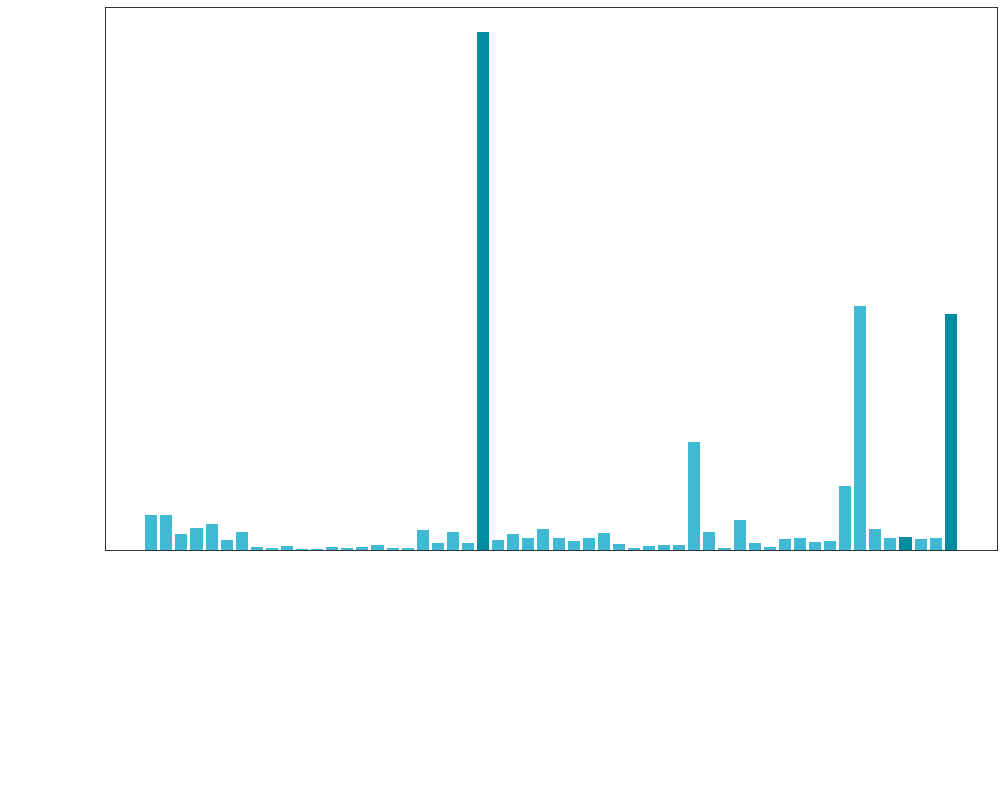

In [17]:
gene = d_sym_ent['DOCK2']

l_bcolor = []
special_tissues = ['Thyroid','Whole Blood','Cells - EBV-transformed lymphocytes']
for t in tissues:
    if t in special_tissues:
        l_bcolor.append('#008CA0')
    else:
        l_bcolor.append('#40b9d4')

expr_vals = d_enz_tissueexpvals[gene]
plt.figure(figsize=(16,10))

plt.bar(tissues,expr_vals, color = l_bcolor)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax = plt.gca()

tick_color = 'w'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=14)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)
# ax.set_xticklabels(tissues,rotation=45 )

In [10]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

Text(1.2, 100.2, 'o')

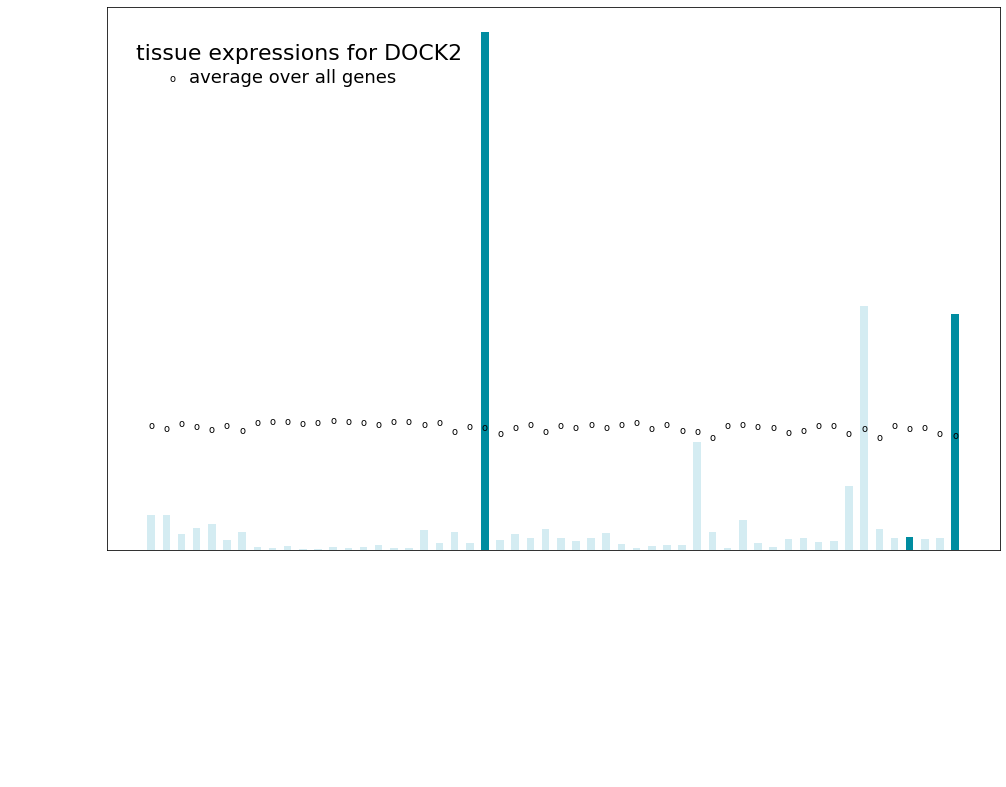

In [15]:
# plt.style.use('dark_background')
plt.style.use('seaborn-deep')

genesym = 'DOCK2'
gene = d_sym_ent[genesym]


d_t_avgtissues = {}
n_genes = len(d_enz_tissueexpvals.keys())
n = 0
for t in tissues:
    tissue_gene = 0
    for ent in d_enz_tissueexpvals.keys():
        tissue_gene += d_enz_tissueexpvals[ent][n]
    d_t_avgtissues[t] = 1.*tissue_gene/n_genes
    n +=1  

l_means = list(d_t_avgtissues.values())


expr_vals = d_enz_tissueexpvals[gene]
plt.figure(figsize=(16,10))

# tissue_xaxis = []
# tissue_xaxis.append('')
# for t in tissues:
#     tissue_xaxis.append(t)
# tissue_xaxis.append('')
# tissue_xaxis.append('')


# exp_yaxis = []
# exp_yaxis.append(0)
# for e in expr_vals:
#     exp_yaxis.append(e)
# exp_yaxis.append(0)
# exp_yaxis.append(0)

    
l_bcolor = []
special_tissues = ['Thyroid','Whole Blood','Cells - EBV-transformed lymphocytes']
# for t in tissue_xaxis:
for t in tissues:
    if t in special_tissues:
        l_bcolor.append('#008CA0')
    else:
        l_bcolor.append('#d4ecf2')

plt.bar(tissues,expr_vals, color = l_bcolor,width=.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Expression level', fontsize = 18)

ax = plt.gca()

tick_color = 'w'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=14)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)
# ax.scatter(tissues,l_means)

# Text on the top of each barplot
for i in range(len(tissues)):
#     plt.text(x = range(len(tissues))[i]-0.5 , y = expr_vals[i]-1, s = tissues[i], size = 6)
    plt.text(x = range(len(tissues))[i]-.2 , y = l_means[i], s = 'o', size = 10)

plt.text(x = -1. , y = 105, s = 'tissue expressions for %s' %genesym, size = 22)
plt.text(x = 1. , y = 100, s = '    average over all genes', size = 18)
plt.text(x = 1.2 , y = 100.2, s = 'o', size = 10)





# ax.set_xticklabels(tissues,rotation=45 )

In [20]:
print(rd.randrange(10))

8


In [69]:
tissue_xaxis = []
tissue_xaxis.append('')
for t in tissues:
    tissue_xaxis.append(t)
tissue_xaxis.append('')

print(tissue_xaxis)

exp_yaxis = []
exp_yaxis.append(0)
for e in expr_vals:
    exp_yaxis.append(e)
exp_yaxis.append(0)


print(exp_yaxis)



['', 'Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)', 'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary', 'Artery - Tibial', 'Bladder', 'Brain - Amygdala', 'Brain - Anterior cingulate cortex (BA24)', 'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere', 'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)', 'Brain - Hippocampus', 'Brain - Hypothalamus', 'Brain - Nucleus accumbens (basal ganglia)', 'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)', 'Brain - Substantia nigra', 'Breast - Mammary Tissue', 'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes', 'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid', 'Colon - Transverse', 'Esophagus - Gastroesophageal Junction', 'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Fallopian Tube', 'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Kidney - Cortex', 'Kidney - Medulla', 'Liver', 'Lung', 'Minor Salivary Gland', 'Muscle - Skeletal', 'Nerve 

In [22]:
json_str = [{"symbol": x, "frequency": rd.randrange(50), "color": "#40b9d4"} for x in tissues]
print(json_str)

[{'symbol': 'Adipose - Subcutaneous', 'frequency': 4, 'color': '#40b9d4'}, {'symbol': 'Adipose - Visceral (Omentum)', 'frequency': 33, 'color': '#40b9d4'}, {'symbol': 'Adrenal Gland', 'frequency': 20, 'color': '#40b9d4'}, {'symbol': 'Artery - Aorta', 'frequency': 3, 'color': '#40b9d4'}, {'symbol': 'Artery - Coronary', 'frequency': 24, 'color': '#40b9d4'}, {'symbol': 'Artery - Tibial', 'frequency': 21, 'color': '#40b9d4'}, {'symbol': 'Bladder', 'frequency': 10, 'color': '#40b9d4'}, {'symbol': 'Brain - Amygdala', 'frequency': 41, 'color': '#40b9d4'}, {'symbol': 'Brain - Anterior cingulate cortex (BA24)', 'frequency': 9, 'color': '#40b9d4'}, {'symbol': 'Brain - Caudate (basal ganglia)', 'frequency': 37, 'color': '#40b9d4'}, {'symbol': 'Brain - Cerebellar Hemisphere', 'frequency': 4, 'color': '#40b9d4'}, {'symbol': 'Brain - Cerebellum', 'frequency': 20, 'color': '#40b9d4'}, {'symbol': 'Brain - Cortex', 'frequency': 41, 'color': '#40b9d4'}, {'symbol': 'Brain - Frontal Cortex (BA9)', 'freque

In [15]:
d_t_avgtissues = {}
n_genes = len(d_enz_tissueexpvals.keys())
n = 0
for t in tissues:
    tissue_gene = 0
    for ent in d_enz_tissueexpvals.keys():
        tissue_gene += d_enz_tissueexpvals[ent][n]
    d_t_avgtissues[t] = 1.*tissue_gene/n_genes
    n +=1    
        

In [22]:
d_t_avgtissues.values()

dict_values([25.96681232622609, 25.407110540646844, 26.46945043886258, 25.934734433536264, 25.176085289750937, 25.98557576140014, 25.02475142437689, 26.67275058326416, 26.814213645444436, 26.897382756602013, 26.404987483133656, 26.679026639082146, 27.153200861522887, 26.93789037255306, 26.764301560848228, 26.232421934320175, 26.871407915975464, 27.001158918246063, 26.345619177379962, 26.60743793991697, 24.866558757545384, 25.918182634944824, 25.68587294265458, 24.270178787524873, 25.687187322743377, 26.266642287910535, 24.82214443632002, 26.07985818480038, 25.697363027261286, 26.358548877930712, 25.68440783398701, 26.352284003950754, 26.697035783449152, 25.349182683749095, 26.329136019158867, 25.061312044857356, 24.715367665528085, 23.487308435260736, 25.954422131193642, 26.23866799891191, 25.935739542341082, 25.660797916445983, 24.632764113074145, 24.905644406888193, 25.944027522765754, 26.081747017875482, 24.350944931572222, 25.308138724636557, 23.57556049508633, 25.97794581643922, 2

In [16]:
d_t_avgtissues

       
    
    

{'Adipose - Subcutaneous': 25.96681232622609,
 'Adipose - Visceral (Omentum)': 25.407110540646844,
 'Adrenal Gland': 26.46945043886258,
 'Artery - Aorta': 25.934734433536264,
 'Artery - Coronary': 25.176085289750937,
 'Artery - Tibial': 25.98557576140014,
 'Bladder': 25.02475142437689,
 'Brain - Amygdala': 26.67275058326416,
 'Brain - Anterior cingulate cortex (BA24)': 26.814213645444436,
 'Brain - Caudate (basal ganglia)': 26.897382756602013,
 'Brain - Cerebellar Hemisphere': 26.404987483133656,
 'Brain - Cerebellum': 26.679026639082146,
 'Brain - Cortex': 27.153200861522887,
 'Brain - Frontal Cortex (BA9)': 26.93789037255306,
 'Brain - Hippocampus': 26.764301560848228,
 'Brain - Hypothalamus': 26.232421934320175,
 'Brain - Nucleus accumbens (basal ganglia)': 26.871407915975464,
 'Brain - Putamen (basal ganglia)': 27.001158918246063,
 'Brain - Spinal cord (cervical c-1)': 26.345619177379962,
 'Brain - Substantia nigra': 26.60743793991697,
 'Breast - Mammary Tissue': 24.866558757545384

In [93]:
top = d_rk_variants[1]
print('degree for candidate %s (%s): %s\n' %(top,d_ent_sym[top],G_ppi.degree(top)))

print('Annotated phenotypes of seeds in neighborhood (sorted by specificity desc):')
neighboring_seeds = set(G_ppi.neighbors(top)) & l_seeds_onppi
for gene in neighboring_seeds:
    print(gene,d_ent_sym[gene])
    
    d_hpo_spec_level = {}
    for x in d_gene_hpo[gene]:
        level = nx.shortest_path_length(G_hpo,x,hpo_tip)
        d_hpo_spec_level[x] = level
#         print(x,d_HPOterms_name[x])
    tbl = PrettyTable(['hpo','phenotype name','specificity'])


    for hpo,level in sorted(d_hpo_spec_level.items(),key = lambda x: x[1], reverse = True):
        if level > 2:
            tbl.add_row([hpo,d_HPOterms_name[hpo],level])


    tbl.align['phenotype name'] = 'l'


    print(tbl)

degree for candidate 64794 (DDX31): 107

Annotated phenotypes of seeds in neighborhood (sorted by specificity desc):
3507 IGHM
+------------+---------------------------------------------------------+-------------+
|    hpo     | phenotype name                                          | specificity |
+------------+---------------------------------------------------------+-------------+
| HP:0006532 | Recurrent pneumonia                                     |      7      |
| HP:0002110 | Bronchiectasis                                          |      7      |
| HP:0004432 | Agammaglobulinemia                                      |      7      |
| HP:0011991 | Abnormal neutrophil cell number                         |      7      |
| HP:0010976 | B lymphocytopenia                                       |      7      |
| HP:0011108 | Recurrent sinusitis                                     |      7      |
| HP:0001287 | Meningitis                                              |      6      |
| H

# DISEASE

In [95]:
top = d_rk_variants[1]
print('degree for candidate %s (%s): %s\n' %(top,d_ent_sym[top],G_ppi.degree(top)))

print('Annotated diseases of seeds in neighborhood (sorted by specificity desc):')
neighboring_seeds = set(G_ppi.neighbors(top)) & l_seeds_onppi
for gene in neighboring_seeds:
    print(gene,d_ent_sym[gene])
    
    d_do_spec_level = {}
    for x in d_gene_do[gene]:
        level = nx.shortest_path_length(G_DO_un,x,tree_tip)
        d_do_spec_level[x] = level
#         print(x,d_HPOterms_name[x])
    tbl = PrettyTable(['DO-ID','disease','specificity'])


    for do,level in sorted(d_do_spec_level.items(),key = lambda x: x[1], reverse = True):
        if level > 2:
            tbl.add_row([do,d_do_names[do],level])


    tbl.align['disease'] = 'l'


    print(tbl)

degree for candidate 64794 (DDX31): 107

Annotated diseases of seeds in neighborhood (sorted by specificity desc):
3507 IGHM
+--------------+----------------------------------+-------------+
|    DO-ID     | disease                          | specificity |
+--------------+----------------------------------+-------------+
|  DOID:6195   | conjunctivitis                   |      7      |
|  DOID:10754  | otitis media                     |      6      |
|  DOID:8577   | ulcerative colitis               |      6      |
|   DOID:381   | arthropathy                      |      6      |
| DOID:0060192 | Crohn's colitis                  |      6      |
|   DOID:848   | arthritis                        |      6      |
| DOID:0050127 | sinusitis                        |      6      |
|  DOID:4251   | conjunctival disease             |      6      |
|  DOID:1352   | paranasal sinus disease          |      5      |
| DOID:0060180 | colitis                          |      5      |
|  DOID:8778   | 

# TISSUES

In [98]:
top = d_rk_variants[1]
print('degree for candidate %s (%s): %s\n' %(top,d_ent_sym[top],G_ppi.degree(top)))

print('Annotated tissues of seeds in neighborhood:')
neighboring_seeds = set(G_ppi.neighbors(top)) & l_seeds_onppi
for gene in neighboring_seeds:
    print(gene,d_ent_sym[gene])
    
    tbl = PrettyTable(['tissue','level'])

    for x in d_gene_ts_level[gene]:
        if x[1] == 'High':
            tbl.add_row([x[0],x[1]])


        
        
#         level = nx.shortest_path_length(G_DO_un,x,tree_tip)
#         d_do_spec_level[x] = level
# #         print(x,d_HPOterms_name[x])
#     tbl = PrettyTable(['DO-ID','disease','specificity'])


#     for do,level in sorted(d_do_spec_level.items(),key = lambda x: x[1], reverse = True):
#         if level > 2:
#             tbl.add_row([do,d_do_names[do],level])


    tbl.align['tissue'] = 'l'


    print(tbl)

degree for candidate 64794 (DDX31): 107

Annotated tissues of seeds in neighborhood:
3507 IGHM
+--------+-------+
| tissue | level |
+--------+-------+
+--------+-------+
718 C3
+--------+-------+
| tissue | level |
+--------+-------+
+--------+-------+
1736 DKC1
+-------------------+-------+
| tissue            | level |
+-------------------+-------+
| adrenal gland     |  High |
| appendix          |  High |
| bone marrow       |  High |
| bronchus          |  High |
| caudate           |  High |
| cerebellum        |  High |
| cerebral cortex   |  High |
| cervix uterine    |  High |
| colon             |  High |
| duodenum          |  High |
| endometrium 1     |  High |
| endometrium 2     |  High |
| epididymis        |  High |
| esophagus         |  High |
| fallopian tube    |  High |
| gallbladder       |  High |
| heart muscle      |  High |
| hippocampus       |  High |
| kidney            |  High |
| liver             |  High |
| lung              |  High |
| lymph node    

In [113]:
print(d_sym_ent['DOCK2'])
print(d_sym_ent['DOK3'])




1794
79930


In [112]:
gene = d_sym_ent['DOCK2']

# print(d_sym_ent['DDX31'])
# print(gene,d_ent_sym['64794'])

tbl = PrettyTable(['tissue','level'])

for x in d_gene_ts_level[gene]:
#     if x[1] == 'High':
    tbl.add_row([x[0],x[1]])




#         level = nx.shortest_path_length(G_DO_un,x,tree_tip)
#         d_do_spec_level[x] = level
# #         print(x,d_HPOterms_name[x])
#     tbl = PrettyTable(['DO-ID','disease','specificity'])


#     for do,level in sorted(d_do_spec_level.items(),key = lambda x: x[1], reverse = True):
#         if level > 2:
#             tbl.add_row([do,d_do_names[do],level])


tbl.align['tissue'] = 'l'


print(tbl)

+---------------+--------+
| tissue        | level  |
+---------------+--------+
| appendix      |  High  |
| bone marrow   |  High  |
| breast        |  Low   |
| colon         |  Low   |
| gallbladder   |  Low   |
| kidney        |  Low   |
| lung          | Medium |
| lymph node    |  High  |
| skin 1        | Medium |
| soft tissue 2 |  Low   |
| spleen        | Medium |
| spleen        |  High  |
| stomach 1     |  Low   |
| stomach 2     |  Low   |
| tonsil        |  High  |
+---------------+--------+


# FUNCTIONS (GO- F)

In [28]:
top = d_rk_variants[2]
print('degree for candidate %s (%s): %s\n' %(top,d_ent_sym[top],G_ppi.degree(top)))

print('Annotated diseases of seeds in neighborhood (sorted by specificity desc):')
neighboring_seeds = set(G_ppi.neighbors(top)) & l_seeds_onppi
for gene in neighboring_seeds:
    print(gene,d_ent_sym[gene])
    
    d_go_spec_level = {}
    for x in d_gene_gomol[gene]:
        level = nx.shortest_path_length(G_GOmol_up,x,moltip)
        d_go_spec_level[x] = level
#         print(x,d_HPOterms_name[x])
    tbl = PrettyTable(['GO-ID','function','specificity'])


    for go,level in sorted(d_go_spec_level.items(),key = lambda x: x[1], reverse = True):
        if level > 2:
            tbl.add_row([go,d_gomol_name[go],level])


tbl.align['function'] = 'l'


print(tbl)

degree for candidate 64794 (DDX31): 107

Annotated diseases of seeds in neighborhood (sorted by specificity desc):
1736 DKC1
+------------+-----------------------------------------------------------------+-------------+
|   GO-ID    | function                                                        | specificity |
+------------+-----------------------------------------------------------------+-------------+
| GO:0003720 | telomerase activity                                             |      5      |
| GO:0070034 | telomerase RNA binding                                          |      5      |
| GO:0016779 | nucleotidyltransferase activity                                 |      4      |
| GO:0003964 | RNA-directed DNA polymerase activity                            |      4      |
| GO:0003723 | RNA binding                                                     |      4      |
| GO:0009982 | pseudouridine synthase activity                                 |      4      |
| GO:0016772 | trans

In [119]:
top = d_sym_ent['DOK3']

print(top,d_ent_sym[top])

d_go_spec_level = {}
for x in d_gene_gomol[top]:
    level = nx.shortest_path_length(G_GOmol_up,x,moltip)
    d_go_spec_level[x] = level
#         print(x,d_HPOterms_name[x])
tbl = PrettyTable(['GO-ID','function','specificity'])


for go,level in sorted(d_go_spec_level.items(),key = lambda x: x[1], reverse = True):
    if level > 2:
        tbl.add_row([go,d_gomol_name[go],level])


tbl.align['function'] = 'l'


print(tbl)

79930 DOK3
+-------+----------+-------------+
| GO-ID | function | specificity |
+-------+----------+-------------+
+-------+----------+-------------+


# SUBGRAPHS

In [120]:
l_seeds_vars = l_seeds_onppi | l_vars_onppi


G_sub = nx.subgraph(G_ppi,l_seeds_vars)

G = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


print('Size of subgraph: %s' %G_sub.number_of_nodes())
print('# edges of subgraph: %s' %G_sub.number_of_edges())

print('Size of lcc: %s' %G.number_of_nodes())
print('# edges in lcc: %s' %G.number_of_edges())




Size of subgraph: 284
# edges of subgraph: 430
Size of lcc: 187
# edges in lcc: 413


In [87]:
print('Genes in seeds + variants lcc:')
for gene in G.nodes():
    print(gene,d_ent_sym[gene])

Genes in seeds + variants lcc:
5728 PTEN
57591 MKL1
10525 HYOU1
641 BLM
11151 CORO1A
80169 CTC1
3716 JAK1
8676 STX11
718 C3
925 CD8A
712 C1QA
3702 ITK
1789 DNMT3B
2357 FPR1
4522 MTHFD1
84433 CARD11
25939 SAMHD1
1441 CSF3R
5903 RANBP2
23495 TNFRSF13B
1380 CR2
716 C1S
100 ADA
729 C6
731 C8A
6813 STXBP2
51119 SBDS
915 CD3D
23385 NCSTN
29988 SLC2A8
710 SERPING1
3514 IGKC
5199 CFP
8772 FADD
65057 ACD
4683 NBN
23586 DDX58
356 FASLG
3075 CFH
4179 CD46
6777 STAT5B
55851 PSENEN
10456 HAX1
9636 ISG15
5880 RAC2
7454 WAS
5295 PIK3R1
5580 PRKCD
4688 NCF2
1051 CEBPB
4068 SH2D1A
733 C8G
64858 DCLRE1B
715 C1R
5788 PTPRC
3665 IRF7
1536 CYBB
9020 MAP3K14
472 ATM
6929 TCF3
1438 CSF2RA
54617 INO80
2624 GATA2
4615 MYD88
8542 APOL1
567 B2M
29110 TBK1
3455 IFNAR2
8808 IL1RL2
29760 BLNK
148022 TICAM1
55072 RNF31
3587 IL10RA
355 FAS
629 CFB
930 CD19
843 CASP10
714 C1QC
51135 IRAK4
8600 TNFSF11
7297 TYK2
56160 NSMCE3
1439 CSF2RB
6774 STAT3
732 C8B
11277 TREX1
146206 CARMIL2
3588 IL10RB
5971 RELB
713 C1QB
11274 

# 3D PREVIEW

In [127]:

# load holodeck ppi spring layout
f = open('ppi_Holo_springlayout.csv','r')
lines = f.readlines()
d_entz_xyz = {}
l_x = []
l_y = []
l_z = []

l_xs = []
l_ys = []
l_zs = []

l_xv = []
l_yv = []
l_zv = []

l_color = []
for line in lines[1:]:
#     print(line)
    entz = line.strip().split(',')[0]
    x = line.strip().split(',')[1]
    y = line.strip().split(',')[2]
    z = line.strip().split(',')[3]
    d_entz_xyz[entz] = (x,y,z)
    l_x.append(x)
    l_y.append(y)
    l_z.append(z)
    
    
    if entz in ['1794']:
        l_color.append('#f8b100')
        l_xs.append(x)
        l_ys.append(y)
        l_zs.append(z)
        
    elif entz in l_vars_onppi:
        l_color.append('#40b9d4')
        l_xs.append(x)
        l_ys.append(y)
        l_zs.append(z)
    elif entz in l_seeds_onppi:
        l_color.append('#2ceb13')
        l_xs.append(x)
        l_ys.append(y)
        l_zs.append(z)
#     else:
#         l_color.append('#ababab')





f.close()

In [129]:




Xe=[]
Ye=[]
Ze=[]
for e in G_sub.edges():
    Xe += [d_entz_xyz[e[0]][0],d_entz_xyz[e[1]][0],None]
    Ye += [d_entz_xyz[e[0]][1],d_entz_xyz[e[1]][1],None]
    Ze += [d_entz_xyz[e[0]][2],d_entz_xyz[e[1]][2],None]
    
# EDGES    
trace0=Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
#                line=Line(color='#333333', width=1),

#                 line=Line(color=d_cl_col[cid], width=1),
                line=Line(color='#d4ecf2', width=4),

                 opacity = .5,
               hoverinfo='none'
               )   

Xe=[]
Ye=[]
Ze=[]
for e in G.edges():
    Xe += [d_entz_xyz[e[0]][0],d_entz_xyz[e[1]][0],None]
    Ye += [d_entz_xyz[e[0]][1],d_entz_xyz[e[1]][1],None]
    Ze += [d_entz_xyz[e[0]][2],d_entz_xyz[e[1]][2],None]
    
# EDGES    
trace00=Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
#                line=Line(color='#333333', width=1),

#                 line=Line(color=d_cl_col[cid], width=1),
                line=Line(color='#d2323c', width=4),

                 opacity = .5,
               hoverinfo='none'
               )   

  
# ALL GENES 
trace1=Scatter3d(x=l_x,
               y=l_y,
               z=l_z,
               mode='markers',
               marker=Marker(symbol='circle',
                              size=1,
                             color = '#aaaaaa'
                             ),
#                              color=group,
#                              colorscale='Viridis',
#                              line=Line(color='rgb(50,50,50)', width=0.5)
#                              ),
#                text=labels,
#                hoverinfo='text'

               )

# COLORED NODES    
trace2=Scatter3d(x=l_xs,
               y=l_ys,
               z=l_zs,
               mode='markers',
               marker=Marker(symbol='circle',
                              size=3,
                             color = l_color
                             ),
#                              color=group,
#                              colorscale='Viridis',
#                              line=Line(color='rgb(50,50,50)', width=0.5)
#                              ),
#                text=labels,
#                hoverinfo='text'
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = Layout(
        autosize = True,
         width=100,
         height=100,
         showlegend=False,
    
    )

layout = Layout(
#          scene=scene,
        paper_bgcolor='rgb(0,0,0)'
#     ,
#       annotations=[ann1],
    )

data=Data([trace0,trace00,trace1,trace2])
# data=Data([trace1,trace2])


fig=Figure(data=data,layout = layout)

iplot(fig)
plotly.offline.plot(fig)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area


In [122]:
print(G_ppi.degree(d_sym_ent['RAC1']))

232


In [126]:
set(l_color)

{'#40b9d4', '#f8b100'}

In [128]:
# G = nx.watts_strogatz_graph(100,6,.01)

sp = nx.shortest_path(G_ppi, source=rd.sample(G_ppi.nodes(),1)[0], target=rd.sample(G_ppi.nodes(),1)[0])
print(sp)

spc = [str(x)+',' for x in sp]
spl_str = ''
spl_str = spl_str.join(spc)
spl_str = '(' + spl_str[:-1] + ')'
print(spl_str)

['79098', '4088', '5594', '6197']
(79098,4088,5594,6197)


In [131]:

out_str = '{"nodes":['
for geneid in sp:
    sym = d_ent_sym[geneid]
    name = d_entz_names[geneid]
    out_str += '{"name":"' + name + '","node_id":' + geneid + ',"symbol":"' + sym + '"},'
out_str = out_str[:-1] + '}'
    

In [132]:
print(out_str)

{"nodes":[{"name":"chromosome 1 open reading frame 116","node_id":79098,"symbol":"C1orf116"},{"name":"SMAD family member 3","node_id":4088,"symbol":"SMAD3"},{"name":"mitogen-activated protein kinase 1","node_id":5594,"symbol":"MAPK1"},{"name":"ribosomal protein S6 kinase A3","node_id":6197,"symbol":"RPS6KA3"}}


In [145]:
print(len(l_seeds_onppi))

271


# GENERATE SELECTION INSERT STATMENT FOR ASIMOV

In [ ]:
# FORMAT:

# INSERT INTO ppi.attributes (`id`,`external_id`,`name`,`description`,`namespace`,`root_node`) 
# VALUES (87632,'100,'DOCK2_seeds', 'DOCK2_story', 'SELECTION',NULL); 

In [147]:
f = open('query_insert_selectionseeds.txt','w')

start_id = 87632

caption = "INSERT INTO ppi.attributes (`id`,`external_id`,`name`,`description`,`namespace`,`root_node`)"
f.write('%s\nVALUES ' %(caption))
run_id = start_id
for seed in l_seeds_onppi:
    row = "(%s,'%s','DOCK2_seeds', 'DOCK2_story', 'SELECTION',NULL), " %(run_id,seed)
    f.write('%s\n' %(row))
    run_id += 1 



f.close()

In [148]:


f = open('query_insert_selectionvariants.txt','w')

start_id = 87903

caption = "INSERT INTO ppi.attributes (`id`,`external_id`,`name`,`description`,`namespace`,`root_node`)"
f.write('%s\nVALUES ' %(caption))
run_id = start_id
for seed in l_vars_onppi:
    row = "(%s,'%s','DOCK2_variants', 'DOCK2_story', 'SELECTION',NULL), " %(run_id,seed)
    f.write('%s\n' %(row))
    run_id += 1 



f.close()



In [156]:
d_j_e, d_e_j = jenids2entzids()

In [163]:
jstr = '{"selection_name": "DOCK2_variants","node_ids":['
for seed in l_vars_onppi:
    j_id = d_e_j[seed]
    jstr += '%s'%j_id + ','
    


In [164]:
print(jstr)

{"selection_name": "DOCK2_variants","node_ids":[15266,12890,4530,16688,12388,464,12583,2661,9224,2988,1054,18026,9259,


In [167]:
# Number 

rand_set = l_seeds_onppi
G_sub = nx.subgraph(G_ppi,rand_set)

G = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph

print(G_sub.number_of_nodes())
print(G_sub.number_of_edges())

print(G.number_of_nodes())
print(G.number_of_edges())





181
402
271
419


In [ ]:
# Depth first search starting at variants seeking for seeds

In [208]:
l_linkerset = []

 
start_variant = list(l_vars_onppi)[1]
print('start at variant: %s (k = %s)' %(start_variant,G_ppi.degree(start_variant)))
cc = 1
for path in nx.dfs_edges(G_ppi,start_variant,2):
    if path[0] in l_seeds_onppi:
        print(cc,set(path),'SEED REACHED at d=1')
        l_linkerset.append(path[0])
    if path[1] in l_seeds_onppi:
        print(cc,set(path),'SEED REACHED at d=2')
        l_linkerset.append(path[0])
        l_linkerset.append(path[1])
    else:
        pass
#         print(cc,set(path))
    cc += 1

start at variant: 1794 (k = 33)
98 {'386676', '9841'} SEED REACHED at d=2
133 {'2624', '386676'} SEED REACHED at d=2
168 {'10657', '3702'} SEED REACHED at d=2
172 {'10657', '695'} SEED REACHED at d=2
174 {'3718', '10657'} SEED REACHED at d=2
188 {'10657', '6774'} SEED REACHED at d=2
189 {'5295', '10657'} SEED REACHED at d=2
199 {'8600', '10657'} SEED REACHED at d=2
225 {'60', '10657'} SEED REACHED at d=2
237 {'10657', '841'} SEED REACHED at d=2
240 {'10657', '8772'} SEED REACHED at d=2
297 {'975', '10657'} SEED REACHED at d=2
322 {'23385', '10657'} SEED REACHED at d=2
401 {'100', '4171'} SEED REACHED at d=2
410 {'720', '4171'} SEED REACHED at d=2
415 {'7841', '4171'} SEED REACHED at d=2
451 {'4171', '4860'} SEED REACHED at d=2
456 {'326', '4171'} SEED REACHED at d=2
484 {'4173', '4171'} SEED REACHED at d=2
485 {'472', '4171'} SEED REACHED at d=2
532 {'4171', '10525'} SEED REACHED at d=2
579 {'5903', '4171'} SEED REACHED at d=2
656 {'4522', '4171'} SEED REACHED at d=2
1013 {'2539', '417

In [210]:
set(l_linkerset)

{'100',
 '10456',
 '10525',
 '10657',
 '10758',
 '125115',
 '146206',
 '1535',
 '1794',
 '204',
 '2214',
 '23385',
 '2533',
 '2539',
 '2624',
 '27040',
 '29110',
 '326',
 '356',
 '3611',
 '3689',
 '3702',
 '3718',
 '373',
 '386676',
 '4068',
 '4171',
 '4173',
 '4188',
 '4522',
 '472',
 '4860',
 '5062',
 '5295',
 '5788',
 '5880',
 '5903',
 '60',
 '64170',
 '6772',
 '6774',
 '6777',
 '6890',
 '6891',
 '6929',
 '695',
 '716',
 '720',
 '7297',
 '7454',
 '7535',
 '7841',
 '81570',
 '841',
 '84433',
 '8517',
 '8600',
 '8772',
 '915',
 '916',
 '919',
 '975',
 '9841'}

In [213]:
l_linkerset = []
for start_variant in l_vars_onppi:
    # start_variant = list(l_vars_onppi)[1]
    # print('start at variant: %s (k = %s)' %(start_variant,G_ppi.degree(start_variant)))
    cc = 1
    for path in nx.dfs_edges(G_ppi,start_variant,2):
        if path[0] in l_seeds_onppi:
#             print(cc,set(path),'SEED REACHED at d=1')
            l_linkerset.append(path[0])
        if path[1] in l_seeds_onppi:
#             print(cc,set(path),'SEED REACHED at d=2')
            l_linkerset.append(path[0])
            l_linkerset.append(path[1])
        else:
            pass
    #         print(cc,set(path))
        cc += 1

In [214]:
# flat_linkerset = [item for sublist in l_linkerset for item in sublist]
print(set(l_linkerset))

{'2956', '959', '712', '729', '283455', '386680', '4688', '1380', '5062', '5284', '4924', '23210', '79930', '695', '8844', '4188', '1051', '3010', '103', '3070', '7187', '716', '100', '2624', '64780', '29121', '64794', '10320', '50943', '1794', '79991', '3611', '925', '5184', '5426', '3075', '204', '5073', '8546', '29760', '4204', '148022', '730', '6773', '1604', '916', '51135', '1869', '4171', '7057', '55657', '2533', '27040', '641', '919', '4609', '472', '10456', '10647', '55505', '91039', '3575', '8600', '356', '6772', '9784', '8555', '1493', '51608', '930', '973', '359948', '1441', '4790', '10758', '4068', '331', '10725', '25939', '6786', '843', '54472', '84818', '720', '3192', '1535', '4522', '9636', '1991', '1536', '130340', '3493', '8772', '931', '81857', '147138', '2214', '4173', '6901', '23074', '9020', '10657', '81570', '1736', '4860', '64170', '5896', '3702', '8517', '55651', '1080', '653269', '6774', '958', '115650', '2638', '125115', '355', '7841', '7185', '29988', '841', 

In [217]:
rand_set = set(l_linkerset) | set(l_vars_onppi)
G_sub = nx.subgraph(G_ppi,rand_set)

G = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph

print(G_sub.number_of_nodes())
print(G_sub.number_of_edges())

print(G.number_of_nodes())
print(G.number_of_edges())



221
759
220
759


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



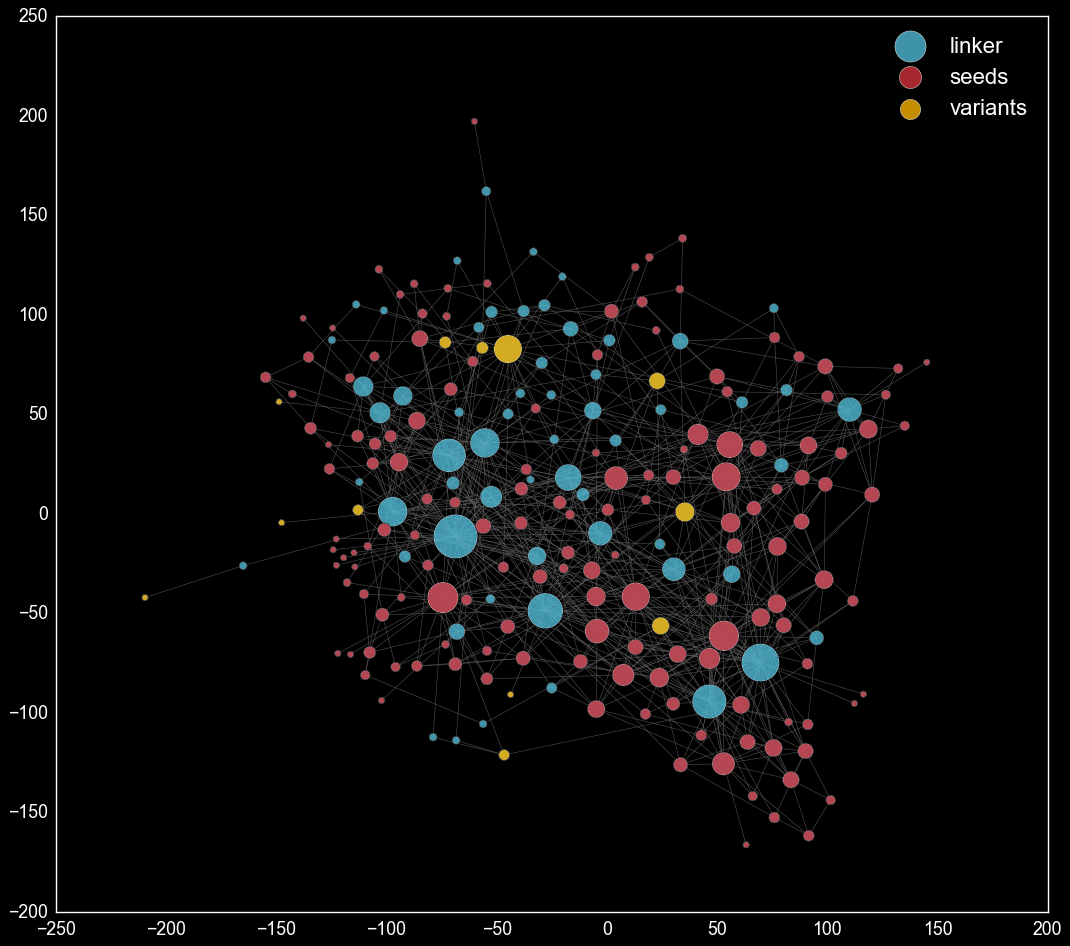

In [223]:


# forceatlas2 = ForceAtlas2()
# posG = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=500)
# crvs = curved_edges(G,pos=posG)

scalef = 15
x = 20
power = 1.2
# ring_frac = np.sqrt((x-1.)/x)
ring_frac = (x-1.)/x

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():

    k = nx.degree(G,node)
    R = scalef*(1+k**power)
    r = ring_frac * R
    l_size_outer.append(R)
    l_size_inner.append(r)
    l_x.append(posG[node][0])
    l_y.append(posG[node][1])




plt.figure(figsize=(16,14))
# crvs = curved_edges(G_result,pos=posG)

# lc = LineCollection(crvs, color='#888888', alpha=0.6)
# plt.gca().add_collection(lc)

edgewidth = .5#[ .8*d['weight'] for (u,v,d) in G_result.edges(data=True)]


# nx.draw_networkx_labels(G_map,pos=posG,with_labels = 1,labels=d_cid_label,node_size = 1,font_size=20)
nx.draw_networkx_edges(G, pos=posG, width=edgewidth,edge_color='#666666',alpha=.8)
plt.scatter(l_x,l_y,s=l_size_inner,c = '#50b9d4',label = 'linker',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():
    if node in l_seeds_onppi:
        k = nx.degree(G,node)
        R = scalef*(1+k**power)
        r = ring_frac * R
        l_size_outer.append(R)
        l_size_inner.append(r)
        l_x.append(posG[node][0])
        l_y.append(posG[node][1])
    else:
        pass
plt.scatter(l_x,l_y,s=l_size_inner,c = '#d2323c',label = 'seeds',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)
# plt.text(l_x[0]-6,l_y[0]-15,special_gene,fontsize = 14)

l_x = []
l_y = []
l_size_outer = []
l_size_inner = []
for node in G.nodes():
    if node in l_vars_onppi:
        k = nx.degree(G,node)
        R = scalef*(1+k**power)
        r = ring_frac * R
        l_size_outer.append(R)
        l_size_inner.append(r)
        l_x.append(posG[node][0])
        l_y.append(posG[node][1])
    else:
        pass
plt.scatter(l_x,l_y,s=l_size_inner,c = '#f8b100',label = 'variants',zorder=2,alpha=.8)
plt.scatter(l_x,l_y,s=l_size_outer,facecolors='none',edgecolors='k',zorder=2)
# plt.text(l_x[0]-6,l_y[0]-15,special_gene,fontsize = 14)


plt.legend(fontsize = 20)
    
ax = plt.gca()

# ax.set_xticks(range(len(l_r)))    
# ax.set_xticklabels(x_ticks, rotation=90) #set the labels and rotate them 90 deg.
tick_color = 'w'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)     

# TEST SET TEST

In [230]:
l_linkerset = []

variants = [99,100,5]
seeds = [1,2,3,4]

ents_vars = [d_j_e[x] for x in variants]
ents_seeds = [d_j_e[x] for x in seeds]



for start_variant in ents_vars:
    # start_variant = list(l_vars_onppi)[1]
    # print('start at variant: %s (k = %s)' %(start_variant,G_ppi.degree(start_variant)))
    cc = 1
    for path in nx.dfs_edges(G_ppi,start_variant,2):
        if path[0] in ents_seeds:
#             print(cc,set(path),'SEED REACHED at d=1')
            l_linkerset.append(path[0])
        if path[1] in ents_seeds:
#             print(cc,set(path),'SEED REACHED at d=2')
            l_linkerset.append(path[0])
            l_linkerset.append(path[1])
        else:
            pass
    #         print(cc,set(path))
        cc += 1
j_linker = [d_e_j[x] for x in l_linkerset]
print(set(j_linker) - set(seeds))



{15465, 16244}
